# Explore and Wrangling Data
**By: M. Alwi Sukra**

**Data exploration** is an approach similar to initial data analysis, whereby a data analyst uses visual exploration to understand what is in a dataset and the characteristics of the data, rather than through traditional data management systems. These characteristics can include size or amount of data, completeness of the data, correctness of the data, possible relationships amongst data elements or files/tables in the data.

**Data wrangling**, sometimes referred to as data munging, is the process of transforming and mapping data from one "raw" data form into another format with the intent of making it more appropriate and valuable for a variety of downstream purposes such as analytics.

#### import useful libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
from sklearn.preprocessing import MinMaxScaler

In [2]:
sns.set(rc={'figure.figsize':(16,14)})

#### import csv for all subject

In [3]:
CSV_PATH = "D:/datasets/ngantuk/csv/"
COLUMNS = ["subject","class_label","frame","rEar","lEar","mar"]
subjects = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10"]

In [4]:
dfs = []
for subject in subjects:
    path = CSV_PATH + subject + '.csv'
    dfs.append(pd.read_csv(path, names=COLUMNS, delimiter=";"))

In [5]:
df = pd.concat(dfs)

In [6]:
df.head()

,subject,class_label,frame,rEar,lEar,mar
0,1,0,1,0.256382,0.283467,0.028597
1,1,0,2,0.249904,0.236515,0.012574
2,1,0,3,0.156127,0.156127,0.018968
3,1,0,4,0.249904,0.242889,0.012192
4,1,0,5,0.285071,0.289970,0.019900


## Data Explore #1

#### boxplot for right eye aspect ratio

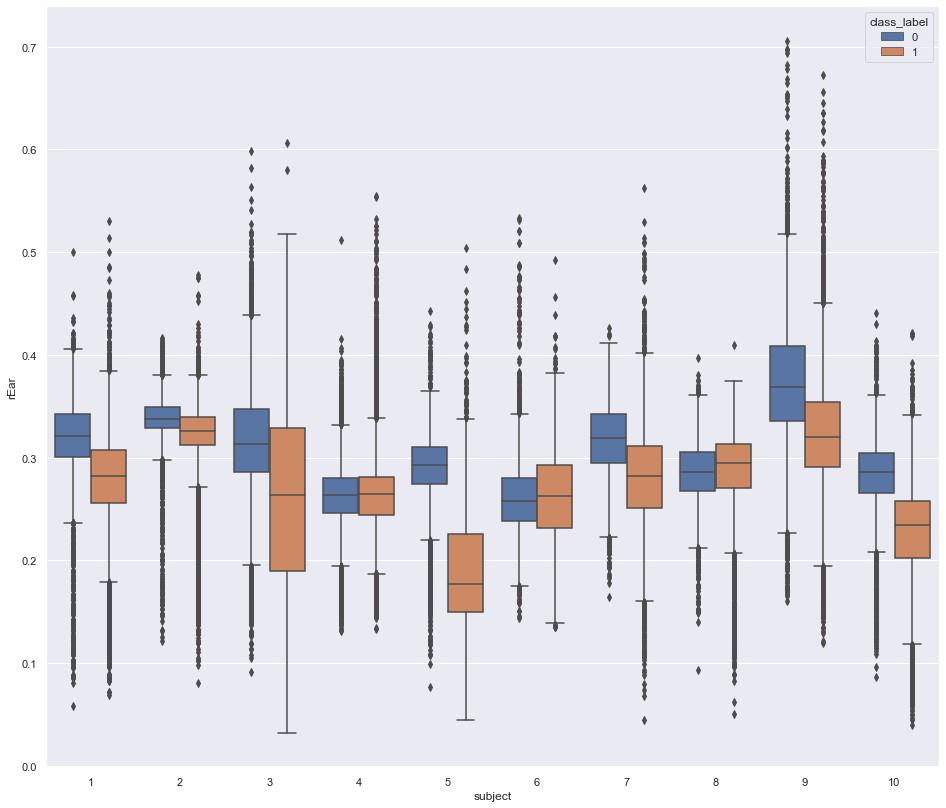

In [7]:
sns.boxplot(x='subject', y='rEar', data=df, hue='class_label')

#### boxplot for left eye aspect ratio

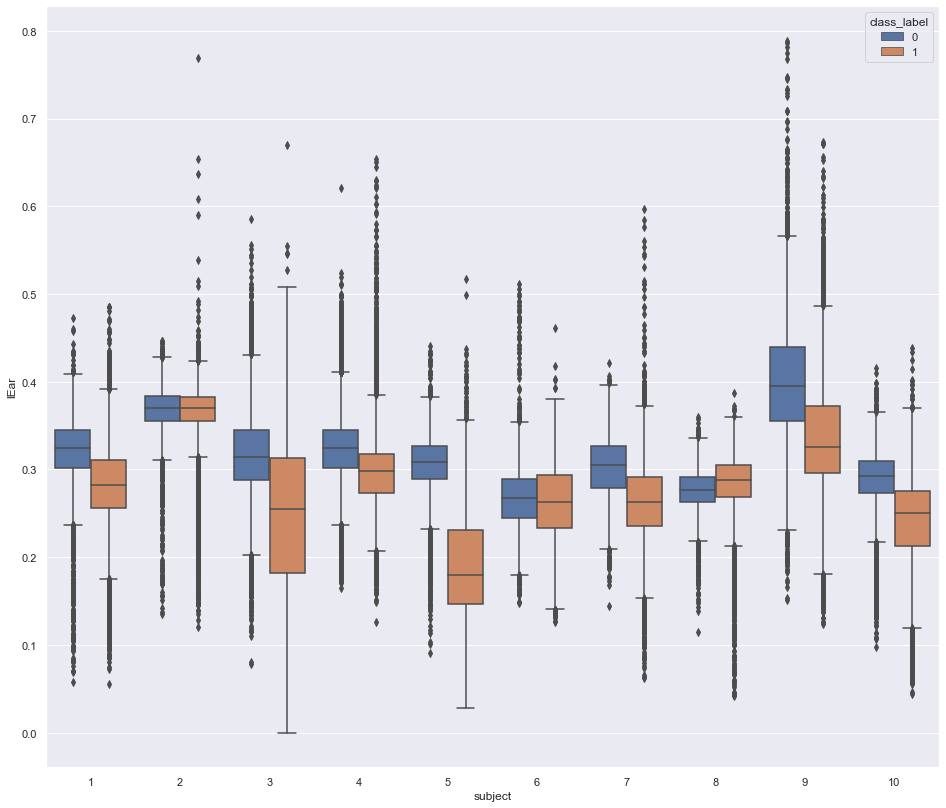

In [8]:
sns.boxplot(x='subject', y='lEar', data=df, hue='class_label')

#### boxplot for mouth aspect ratio

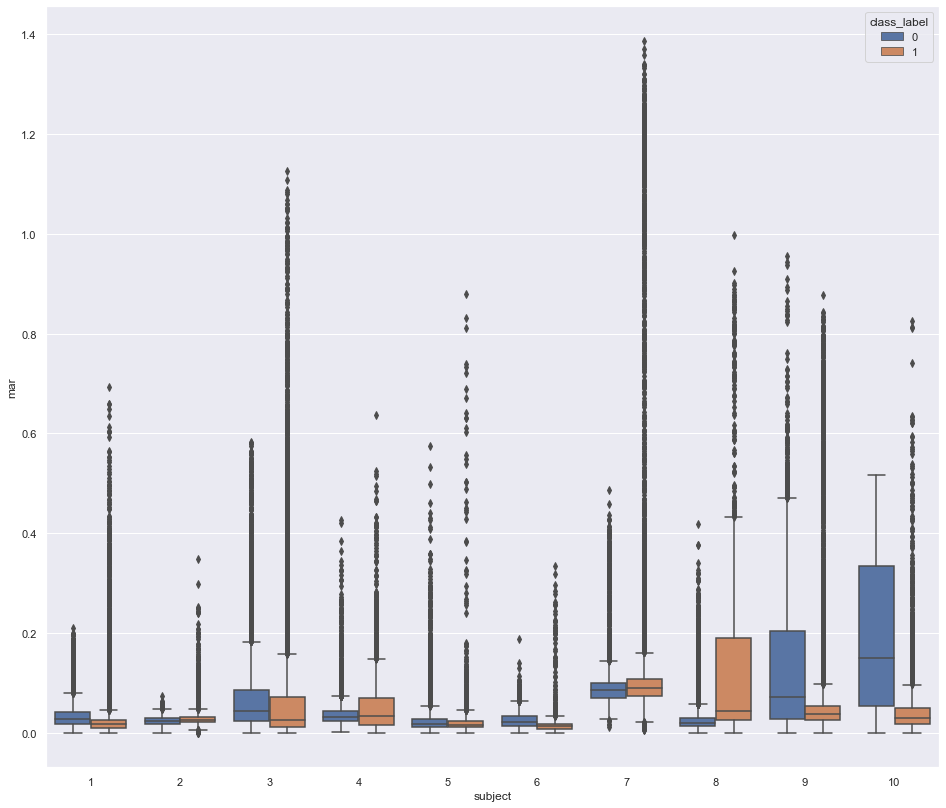

In [9]:
sns.boxplot(x='subject', y='mar', data=df, hue='class_label')

## Data Wrangling #1

Equation used to normalize feature is also used in [this paper](https://arxiv.org/pdf/1904.07312.pdf). They use the first third of the feature of the alert state to compute the mean and standard deviation of each feature for each individual, and then use that values to normalize the rest.

#### define equation

In [10]:
def normalize(input_df, fps, minutes_length):
    calibration_frame = int(fps * 60 * minutes_length)
    # compute mean and std
    means = input_df.loc[(input_df["frame"] > 0) & (input_df["frame"] <= calibration_frame)].mean()
    stds = input_df.loc[(input_df["frame"] > 0) & (input_df["frame"] <= calibration_frame)].std()
    # normalize
    input_df['rEar_norm'] = (input_df['rEar'] - means['rEar']) / stds['rEar']
    input_df['lEar_norm'] = (input_df['lEar'] - means['lEar']) / stds['lEar']
    input_df['mar_norm'] = (input_df['mar'] - means['mar']) / stds['mar']
    return input_df, means, stds

#### get FPS info

In [11]:
FPS_PATH = "D:/datasets/ngantuk/fps_info.txt"

In [12]:
df_fps = pd.read_csv(FPS_PATH, names=['subject','class_label','fps'], delimiter=';', index_col=False)
df_fps.head()

,subject,class_label,fps
0,1,0,24.91
1,1,1,24.91
2,2,0,30.00
3,2,1,30.00
4,3,0,30.03


#### normalize value

In [13]:
MINUTES_LENGTH = 2

In [14]:
dfs_normalize = []
statistics = []
for subject, df_subject in df.groupby('subject'):
    _df = pd.DataFrame(df_subject)
    # get fps for class 0
    fps = df_fps.loc[(df_fps['subject'] == subject) & (df_fps['class_label'] == 0)]['fps'].values[0]
    # normalize
    _df, means, stds = normalize(_df, fps, MINUTES_LENGTH)
    statistics.append([subject, means['rEar'], means['lEar'], means['mar'], stds['rEar'], stds['lEar'], stds['mar']])
    dfs_normalize.append(_df)

In [15]:
df_normalize = pd.concat(dfs_normalize)

In [16]:
df_normalize.head()

,subject,class_label,frame,rEar,lEar,mar,rEar_norm,lEar_norm,mar_norm
0,1,0,1,0.256382,0.283467,0.028597,-0.628895,-0.139827,-0.143620
1,1,0,2,0.249904,0.236515,0.012574,-0.745600,-0.983425,-0.385401
2,1,0,3,0.156127,0.156127,0.018968,-2.435053,-2.427776,-0.288919
3,1,0,4,0.249904,0.242889,0.012192,-0.745600,-0.868902,-0.391171
4,1,0,5,0.285071,0.289970,0.019900,-0.112044,-0.022986,-0.274847


In [17]:
df_statistic = pd.DataFrame(statistics, columns=['subject','mean_rEar','mean_lEar','mean_mar','std_rEar','std_lEar','std_mar'])

In [18]:
df_statistic.head()

,subject,mean_rEar,mean_lEar,mean_mar,std_rEar,std_lEar,std_mar
0,1,0.291290,0.291249,0.038115,0.055507,0.055657,0.066271
1,2,0.331725,0.365555,0.025425,0.029387,0.030480,0.008728
2,3,0.298865,0.293354,0.080800,0.069526,0.067990,0.131152
3,4,0.255562,0.297604,0.037324,0.031327,0.037948,0.030768
4,5,0.247106,0.256431,0.033043,0.064057,0.071658,0.059765


#### Scaling value

In [19]:
print(f"MAX rEar norm: {df_normalize.describe()['rEar_norm']['max']}")
print(f"MIN rEar norm: {df_normalize.describe()['rEar_norm']['min']}")
print(f"MAX lEar norm: {df_normalize.describe()['lEar_norm']['max']}")
print(f"MIN lEar norm: {df_normalize.describe()['lEar_norm']['min']}")  
print(f"MAX mar norm: {df_normalize.describe()['mar_norm']['max']}")
print(f"MIN mar norm: {df_normalize.describe()['mar_norm']['min']}")  

MAX rEar norm: 9.551357871457865
MIN rEar norm: -8.529389281834279
MAX lEar norm: 13.226005866839031
MIN lEar norm: -8.045033478268202
MAX mar norm: 36.96978690896754
MIN mar norm: -2.9130859876919164


In [20]:
scaler = MinMaxScaler(feature_range=(0,1))

In [21]:
df_normalize[['rEar_norm','lEar_norm','mar_norm']] = scaler.fit_transform(df_normalize[['rEar_norm','lEar_norm','mar_norm']])

In [22]:
df_normalize.head()

,subject,class_label,frame,rEar,lEar,mar,rEar_norm,lEar_norm,mar_norm
0,1,0,1,0.256382,0.283467,0.028597,0.436956,0.371642,0.069440
1,1,0,2,0.249904,0.236515,0.012574,0.430502,0.331982,0.063378
2,1,0,3,0.156127,0.156127,0.018968,0.337062,0.264080,0.065797
3,1,0,4,0.249904,0.242889,0.012192,0.430502,0.337366,0.063233
4,1,0,5,0.285071,0.289970,0.019900,0.465542,0.377135,0.066150


## Data Explore #2

#### boxplot for normalized right eye aspect ratio

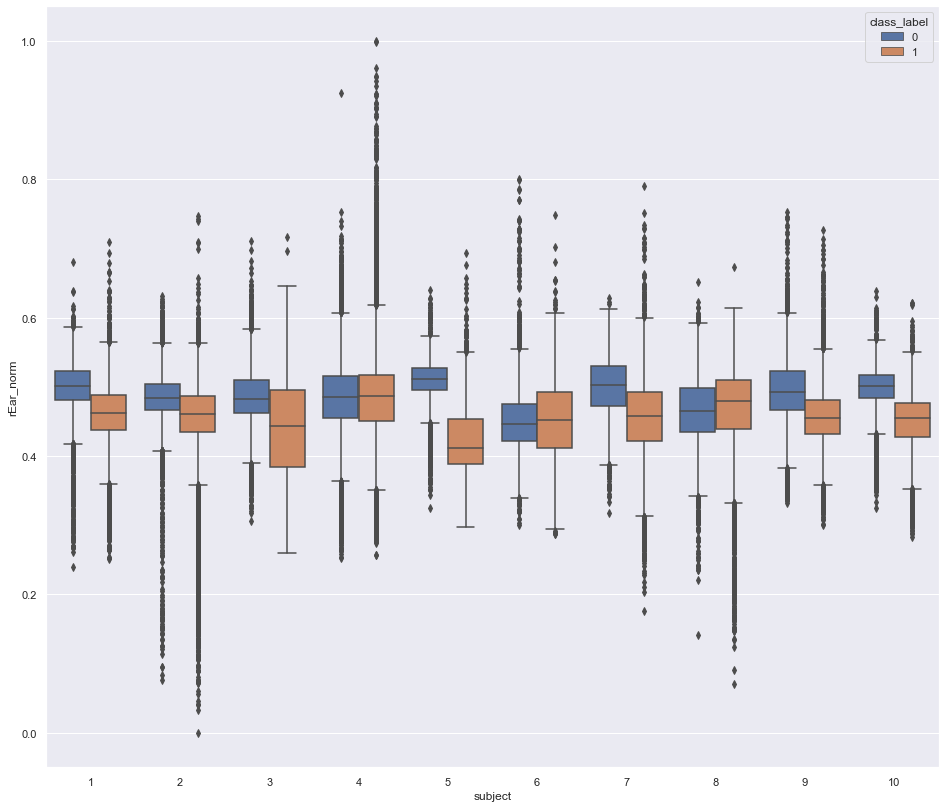

In [23]:
sns.boxplot(x='subject', y='rEar_norm', data=df_normalize, hue='class_label')

#### boxplot for normalized left eye aspect ratio

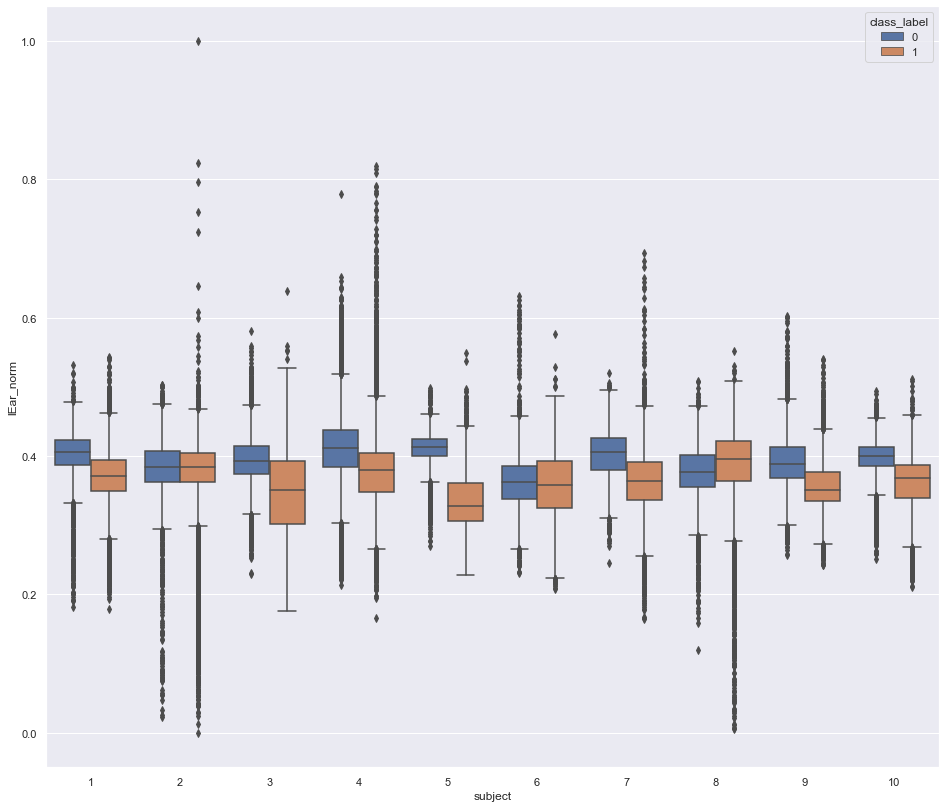

In [24]:
sns.boxplot(x='subject', y='lEar_norm', data=df_normalize, hue='class_label')

#### boxplot for normalized mouth aspect ratio

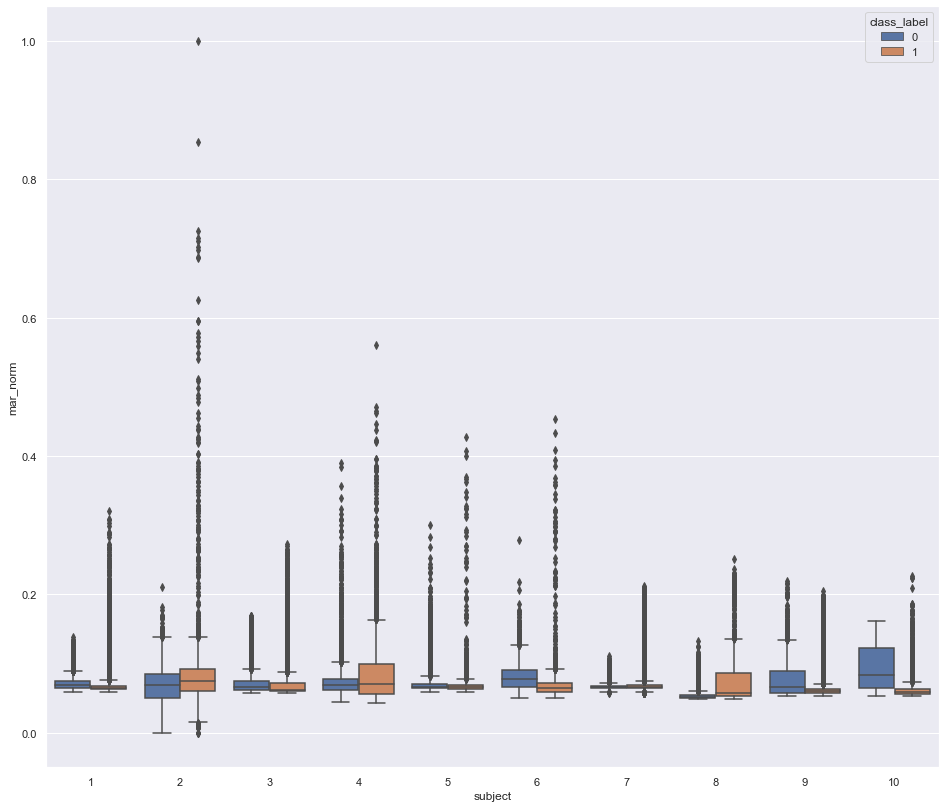

In [25]:
sns.boxplot(x='subject', y='mar_norm', data=df_normalize, hue='class_label')

#### check for null value (NaN)

In [26]:
nan_ratio = []
for subject, df_subject in df_normalize.groupby('subject'):
    _df = pd.DataFrame(df_subject)
    length = len(_df)
    nan_counts = _df.isna().sum()
    # [subject, ratio nan rEar, ratio nan lEar, ratio nan mAr]
    nan_ratio.append([subject, nan_counts['rEar_norm']/length, nan_counts['lEar_norm']/length, nan_counts['mar_norm']/length])

In [27]:
df_nan_ratio = pd.DataFrame(nan_ratio, columns=['subject','rEar_nan_ratio','lEar_nan_ratio','mar_nan_ratio'])

In [28]:
sns.set(rc={'figure.figsize':(8,6)})

rEar

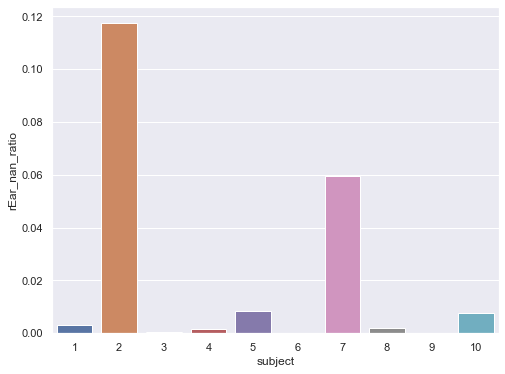

In [29]:
sns.barplot(x='subject', y='rEar_nan_ratio', data=df_nan_ratio)

lEar

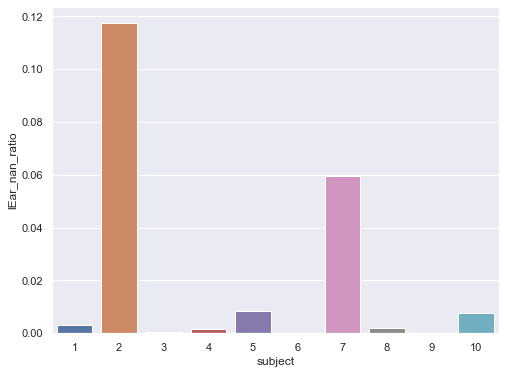

In [30]:
sns.barplot(x='subject', y='lEar_nan_ratio', data=df_nan_ratio)

mar

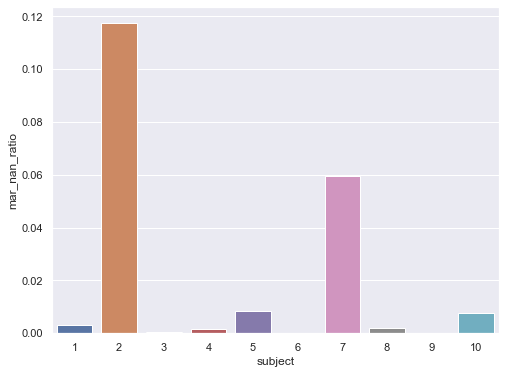

In [31]:
sns.barplot(x='subject', y='mar_nan_ratio', data=df_nan_ratio)

## Data Wrangling #2

#### drop unused columns

In [32]:
df_normalize.drop(columns=['rEar','lEar','mar'], inplace=True)

In [33]:
df_normalize.head()

,subject,class_label,frame,rEar_norm,lEar_norm,mar_norm
0,1,0,1,0.436956,0.371642,0.069440
1,1,0,2,0.430502,0.331982,0.063378
2,1,0,3,0.337062,0.264080,0.065797
3,1,0,4,0.430502,0.337366,0.063233
4,1,0,5,0.465542,0.377135,0.066150


#### fill missing values

In [34]:
df_normalize.interpolate(inplace=True)

check

In [35]:
for subject, df_subject in df_normalize.groupby('subject'):
    _df = pd.DataFrame(df_subject)
    print(f"for subject {subject} there is {_df.isna().sum()['rEar_norm']} missing values")

for subject 1 there is 0 missing values
for subject 2 there is 0 missing values
for subject 3 there is 0 missing values
for subject 4 there is 0 missing values
for subject 5 there is 0 missing values
for subject 6 there is 0 missing values
for subject 7 there is 0 missing values
for subject 8 there is 0 missing values
for subject 9 there is 0 missing values
for subject 10 there is 0 missing values


## Data Explore #3

#### matrix correlation

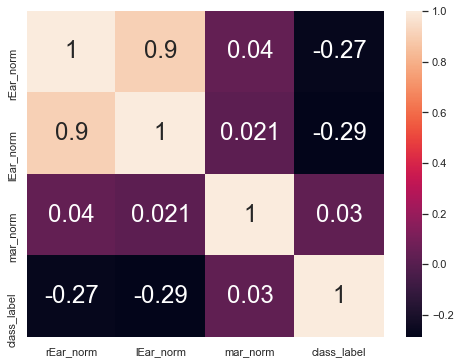

In [36]:
sns.heatmap(df_normalize[['rEar_norm','lEar_norm','mar_norm','class_label']].corr(), annot=True, annot_kws={'size':24})

## Data Wrangling #3

#### get state label for mouth and eye from random sample

In [37]:
LABEL_CSV_PATH = "D:/datasets/ngantuk/random_sample/"
LABEL_COLUMNS = ["subject","class_label","frame","eye_state","mouth_state"]
subjects = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10"]

In [38]:
dfs_state_label = []
for subject in subjects:
    path = LABEL_CSV_PATH + subject + '.csv'
    dfs_state_label.append(pd.read_csv(path, names=LABEL_COLUMNS, delimiter=";", index_col=False))

In [39]:
df_state_label = pd.concat(dfs_state_label)

In [40]:
df_state_label.head()

,subject,class_label,frame,eye_state,mouth_state
0,1,0,1,1,0
1,1,0,3,0,0
2,1,0,95,1,0
3,1,0,237,1,0
4,1,0,256,1,0


#### merge random sample so that it contains generated feature 

In [41]:
df_merged = pd.merge(df_state_label,df_normalize, on=['subject','class_label','frame'])

In [42]:
df_merged.head(5)

,subject,class_label,frame,eye_state,mouth_state,rEar_norm,lEar_norm,mar_norm
0,1,0,1,1,0,0.436956,0.371642,0.069440
1,1,0,3,0,0,0.337062,0.264080,0.065797
2,1,0,95,1,0,0.513630,0.417464,0.064529
3,1,0,237,1,0,0.468391,0.393355,0.062500
4,1,0,256,1,0,0.513522,0.417264,0.071165


#### find the best threshold for eye and mouth

In [43]:
THRESHOLDS = [t/1000 for t in range (100,501,10)]

In [44]:
accuracys = []

In [45]:
for threshold in THRESHOLDS:
    _df = pd.DataFrame(df_merged)
     # default value
    _df['calc_eye_state'] = 1
    _df['calc_mouth_state'] = 0
    # check if eye closed and mouth open
    _df.loc[(_df['rEar_norm'] < threshold) & (_df['lEar_norm'] < threshold), 'calc_eye_state'] = 0
    _df.loc[_df['mar_norm'] > threshold, 'calc_mouth_state'] = 1
    # check correctness
    _df['is_eye_correct'] = 0
    _df['is_mouth_correct'] = 0
    _df.loc[_df['eye_state'] == _df['calc_eye_state'], 'is_eye_correct'] = 1
    _df.loc[_df['mouth_state'] == _df['calc_mouth_state'], 'is_mouth_correct'] = 1
    #check accuracy
    for subject, df_subject in _df.groupby('subject'):
        value_sum = df_subject.sum()
        length = len(df_subject)
        accuracys.append([threshold, subject, value_sum['is_eye_correct'], value_sum['is_mouth_correct']])

In [46]:
df_threshold_accuracy = pd.DataFrame(accuracys, columns=['threshold','subject','eye_state_accuracy','mouth_state_accuracy'])

## Data Explore #4

#### visualize accuracy

In [47]:
sns.set(rc={'figure.figsize':(18,6)})

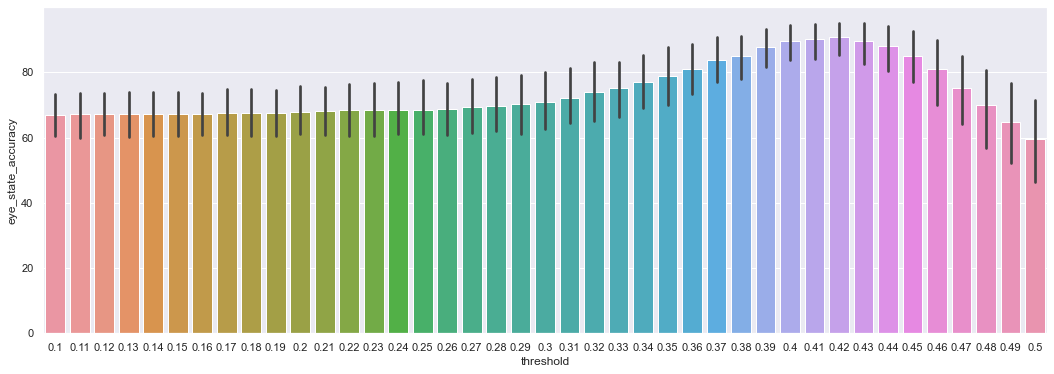

In [48]:
sns.barplot(x="threshold",y="eye_state_accuracy",data=df_threshold_accuracy)

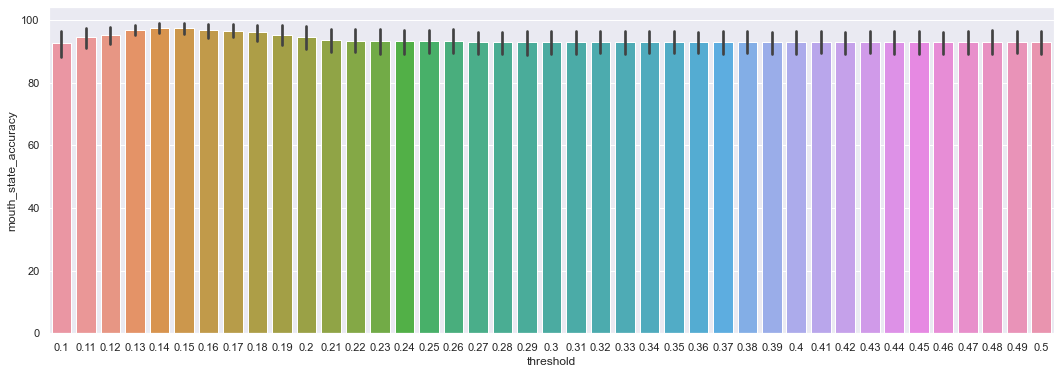

In [49]:
sns.barplot(x="threshold",y="mouth_state_accuracy",data=df_threshold_accuracy)

In [50]:
df_normalize.head()

,subject,class_label,frame,rEar_norm,lEar_norm,mar_norm
0,1,0,1,0.436956,0.371642,0.069440
1,1,0,2,0.430502,0.331982,0.063378
2,1,0,3,0.337062,0.264080,0.065797
3,1,0,4,0.430502,0.337366,0.063233
4,1,0,5,0.465542,0.377135,0.066150


## Data Wrangling #4

#### choose the best threshold for both eye and mouth

In [51]:
EYE_THRESHOLD = 0.42
MOUTH_THRESHOLD = 0.14

#### calculate state of eye and mouth

In [52]:
df_state = pd.DataFrame(df_normalize)

In [53]:
# default value
df_state['calc_eye_state'] = 1
df_state['calc_mouth_state'] = 0
# check if eye closed and mouth open
df_state.loc[(df_state['rEar_norm'] < EYE_THRESHOLD) & (df_state['lEar_norm'] < EYE_THRESHOLD), 'calc_eye_state'] = 0
df_state.loc[df_state['mar_norm'] > MOUTH_THRESHOLD, 'calc_mouth_state'] = 1

In [54]:
df_state.head()

,subject,class_label,frame,rEar_norm,lEar_norm,mar_norm,calc_eye_state,calc_mouth_state
0,1,0,1,0.436956,0.371642,0.069440,1,0
1,1,0,2,0.430502,0.331982,0.063378,1,0
2,1,0,3,0.337062,0.264080,0.065797,0,0
3,1,0,4,0.430502,0.337366,0.063233,1,0
4,1,0,5,0.465542,0.377135,0.066150,1,0


## Data Explore #5

#### matrix correlation

In [55]:
sns.set(rc={'figure.figsize':(8,6)})

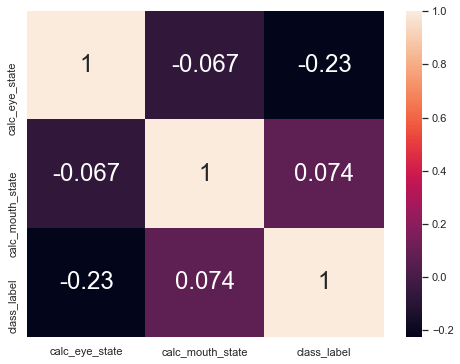

In [56]:
sns.heatmap(df_state[['calc_eye_state','calc_mouth_state','class_label']].corr(), annot=True, annot_kws={'size':24})

## Data Wrangling #5

#### Define function to generate aggregate features

In [57]:
def calculate_perclos(_df, window_size):
    start_frame = 1
    for current_idx in range(window_size+1,len(_df)+1):
        stop_frame = current_idx - 1
        _df.loc[current_idx,'perclos'] = _df.loc[start_frame:stop_frame,'calc_eye_state'].eq(0).sum() / window_size
        start_frame = start_frame + 1  
    return _df

In [58]:
def track_consecutive(_df):
    val_dict = dict([(0, 1), (1, 0)])
    _df['calc_eye_state'].replace(val_dict, inplace=True)
    eye = _df['calc_eye_state']
    mouth = _df['calc_mouth_state']
    _df['btb_eye_closed'] = 0
    _df['btb_mouth_opened'] = 0
    _df['btb_eye_closed'] = eye * (eye.groupby((eye != eye.shift()).cumsum()).cumcount() + 1)
    _df['btb_mouth_opened'] = mouth * (mouth.groupby((mouth != mouth.shift()).cumsum()).cumcount() + 1)
    return _df

In [59]:
def calculate_event_rate(_df, window_size, fps, btb_microsleep, btb_yawning):
    start_frame = 1
    for current_idx in range(window_size+1,len(_df)+1):
        stop_frame = current_idx - 1
        _df.loc[current_idx,'microsleep_rate'] = _df.loc[start_frame:stop_frame,'btb_eye_closed'].eq(btb_microsleep).sum() / (window_size/fps)
        _df.loc[current_idx,'yawning_rate'] = _df.loc[start_frame:stop_frame,'btb_mouth_opened'].eq(btb_yawning).sum() / (window_size/fps)
        start_frame = start_frame + 1  
    return _df

In [60]:
def feature(_df, fps, minutes_length, btb_microsleep_second, btb_yawning_second):
    window_size = int(fps * 60 * minutes_length)
    _df = calculate_perclos(_df, window_size)
    _df = track_consecutive(_df)
    btb_microsleep = btb_microsleep_second * fps
    btb_yawning = btb_yawning_second * fps
    _df = calculate_event_rate(_df, window_size, fps, btb_microsleep, btb_yawning)
    _df.drop(['btb_eye_closed', 'btb_mouth_opened'], axis=1, inplace=True)
    _df.dropna(inplace=True)
    return _df

#### feature engineering

In [61]:
MINUTES_LENGTH = 3
BTB_MICROSLEEP_SECOND = 1
BTB_YAWNING_SECOND = 5

In [62]:
%%time
aggregates = []

for subject, df_subject in df_state.groupby('subject'):
    for class_label, df_class in df_subject.groupby('class_label'):
        # DataFrame for each class
        __df = pd.DataFrame(df_class).set_index('frame')
        # get fps for this subject and class
        fps = df_fps.loc[(df_fps["class_label"] == class_label) & (df_fps["subject"] == subject)].fps.values[0]
        
        # feature engineering
        __df = feature(__df, fps, MINUTES_LENGTH, BTB_MICROSLEEP_SECOND, BTB_YAWNING_SECOND)
        aggregates.append(__df)

Wall time: 2min 35s


In [63]:
df_aggregate = pd.concat(aggregates)

In [64]:
df_aggregate.head()

,subject,class_label,rEar_norm,lEar_norm,mar_norm,calc_eye_state,calc_mouth_state,perclos,microsleep_rate,yawning_rate
frame,,,,,,,,,,
4484,1,0,0.522064,0.441550,0.125197,0,0,0.031452,0.0,0.0
4485,1,0,0.518227,0.430843,0.122614,0,0,0.031452,0.0,0.0
4486,1,0,0.470524,0.406359,0.118601,0,0,0.031452,0.0,0.0
4487,1,0,0.530129,0.420594,0.121653,0,0,0.031229,0.0,0.0
4488,1,0,0.501878,0.396268,0.118319,0,0,0.031229,0.0,0.0


## Data Explore #6

In [65]:
sns.set(rc={'figure.figsize':(12,10)})

#### boxplot for perclos

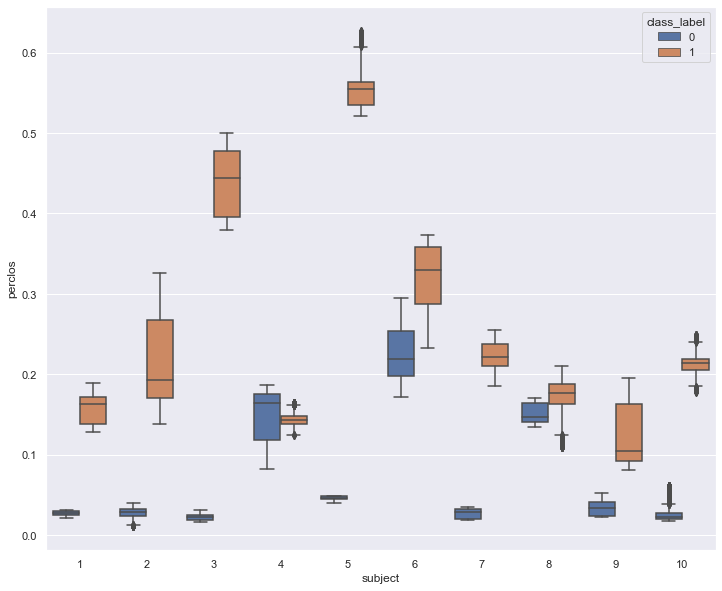

In [66]:
sns.boxplot(x='subject', y='perclos', data=df_aggregate, hue='class_label')

#### boxplot for microsleep rate

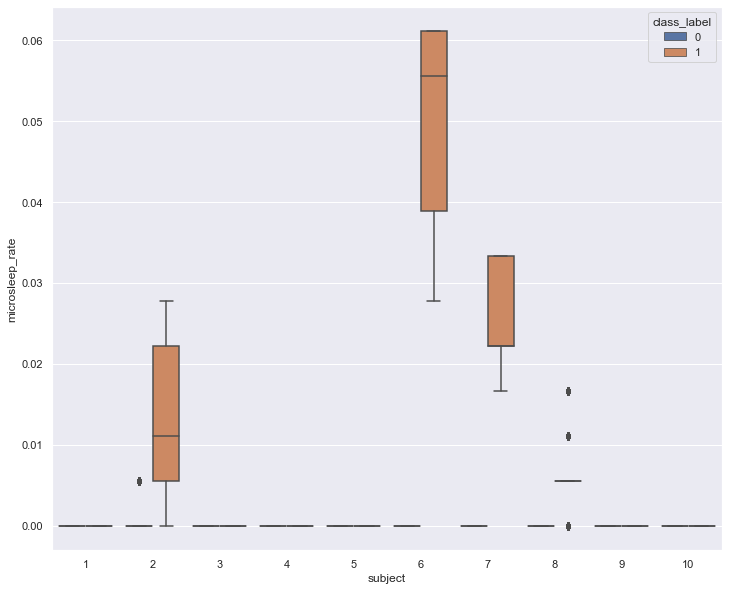

In [67]:
sns.boxplot(x='subject', y='microsleep_rate', data=df_aggregate, hue='class_label')

#### boxplot for yawning rate

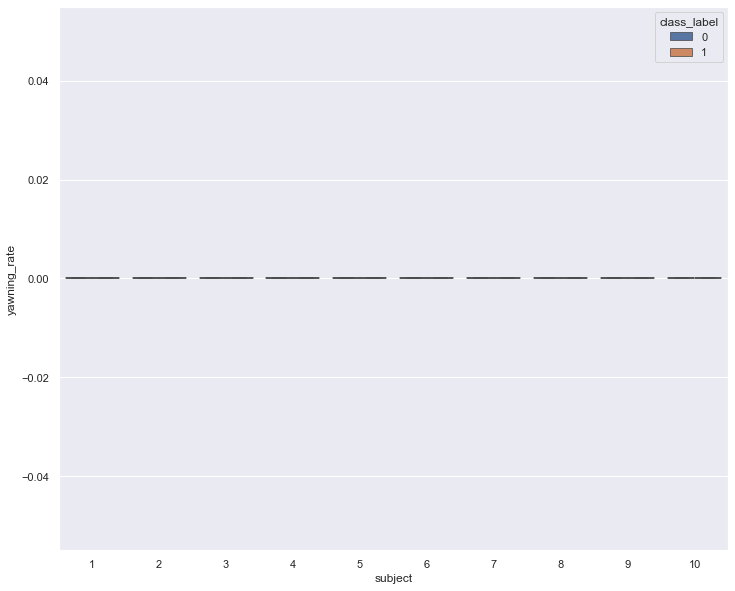

In [68]:
sns.boxplot(x='subject', y='yawning_rate', data=df_aggregate, hue='class_label')

#### matrix correlation

In [69]:
sns.set(rc={'figure.figsize':(8,6)})

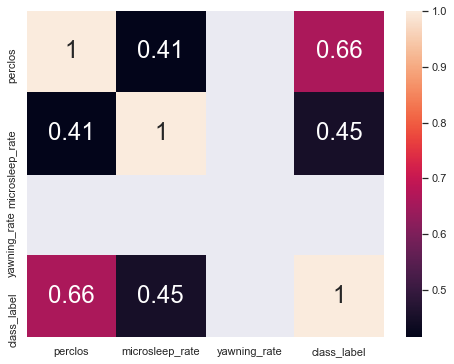

In [70]:
sns.heatmap(df_aggregate[['perclos','microsleep_rate','yawning_rate','class_label']].corr(), annot=True, annot_kws={'size':24})

#### merge with statistic information

In [71]:
df_result = pd.merge(df_aggregate, df_statistic, on=['subject'], how='left')

In [72]:
df_result.head()

,subject,class_label,rEar_norm,lEar_norm,mar_norm,calc_eye_state,calc_mouth_state,perclos,microsleep_rate,yawning_rate,mean_rEar,mean_lEar,mean_mar,std_rEar,std_lEar,std_mar
0,1,0,0.522064,0.441550,0.125197,0,0,0.031452,0.0,0.0,0.29129,0.291249,0.038115,0.055507,0.055657,0.066271
1,1,0,0.518227,0.430843,0.122614,0,0,0.031452,0.0,0.0,0.29129,0.291249,0.038115,0.055507,0.055657,0.066271
2,1,0,0.470524,0.406359,0.118601,0,0,0.031452,0.0,0.0,0.29129,0.291249,0.038115,0.055507,0.055657,0.066271
3,1,0,0.530129,0.420594,0.121653,0,0,0.031229,0.0,0.0,0.29129,0.291249,0.038115,0.055507,0.055657,0.066271
4,1,0,0.501878,0.396268,0.118319,0,0,0.031229,0.0,0.0,0.29129,0.291249,0.038115,0.055507,0.055657,0.066271


#### correlation of all variables

In [73]:
sns.set(rc={'figure.figsize':(18,16)})

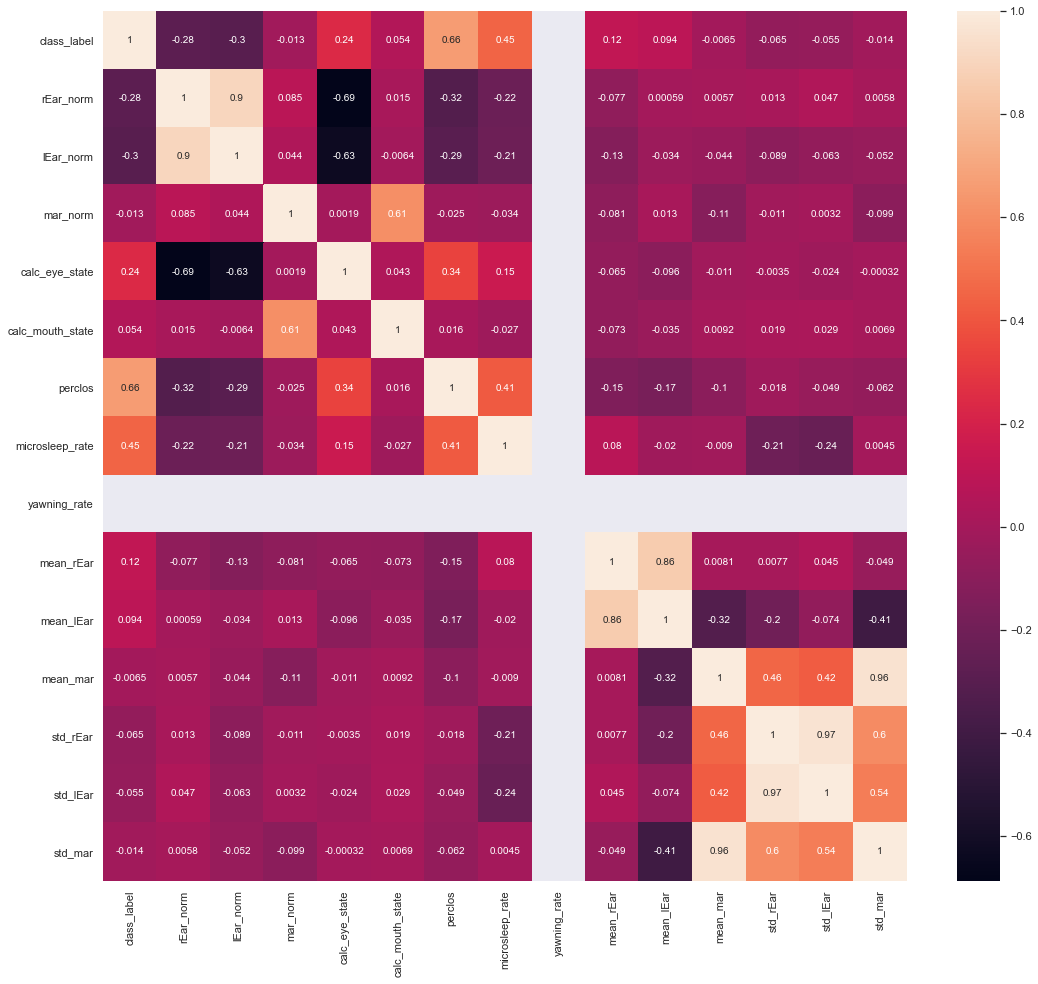

In [74]:
sns.heatmap(df_result[df_result.columns[1:]] .corr(), annot=True, annot_kws={'size':10})

## Save Data

In [77]:
fileName = f"{time.time()}_preprocessed_data.csv"
print(f"filename is {fileName}")

filename is 1592208561.1053133_preprocessed_data.csv


In [78]:
df_result.to_csv('preprocessed_data/'+fileName, index=False)